In [50]:
import pandas as pd
import os
import dask.dataframe as dd
from matplotlib import pyplot as plt
import seaborn as sn

from os.path import join

In [10]:
file_path = os.path.join("..", "..", "data", "TUDA_data", "all_TUDA_data.parquet")
ddf = dd.read_parquet(file_path)
df = ddf.compute()

In [11]:
df

,wagon_ID,loading_state,loading_state_update,altitude,latitude,longitude,signal_quality_satellite,signal_quality_hdop,determination_position,GNSS_velocity,timestamp_measure_position,timestamp_transfer,movement_state,timestamp_measure_movement_state,timestamp_index,provider,wagon_construction,wagon_type
0,763003539712474,1,10 days 02:05:59,397.0,48.532852,12.058022,11.0,3.5,1,89.00,742419.326,874874.235,2.0,742419.326,874879.0,35,43.0,3.0
1,763003539712474,1,10 days 02:05:59,500.0,48.208541,11.540948,11.0,7.2,1,0.00,745231.021,874861.516,1.0,745231.021,874867.0,35,43.0,3.0
2,763003539712474,1,10 days 02:05:59,520.0,48.201575,11.476316,10.0,1.8,1,0.00,747108.221,874854.673,1.0,747108.221,874861.0,35,43.0,3.0
3,763003539712474,1,10 days 02:05:59,520.0,48.201575,11.476316,10.0,1.8,1,0.00,747708.213,874851.673,0.0,747708.213,874860.0,35,43.0,3.0
4,763003539712474,1,10 days 02:05:59,494.0,48.195102,11.496101,8.0,2.2,1,0.00,752905.167,874846.923,1.0,752905.167,874854.0,35,43.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145282,697603229722475,1,1 days 22:45:39,142.0,56.015026,12.765823,5.0,2.0,1,1.44,292457.000,292473.355,1.0,292414.000,292476.0,32,49.0,3.0
145283,697603229722475,1,1 days 22:45:39,19.0,56.021461,12.767638,5.0,2.0,1,0.36,292022.000,292039.637,1.0,291951.000,292042.0,32,49.0,3.0
145284,697603229722475,1,1 days 22:45:39,NaN,56.025329,12.724382,NaN,NaN,4,NaN,289169.000,291807.267,2.0,291684.000,291809.0,32,49.0,3.0
145285,697603229722475,1,1 days 22:45:39,71.0,56.025311,12.724693,0.0,2.0,1,0.00,287385.000,287399.348,1.0,287325.000,287401.0,32,49.0,3.0


In [12]:
def get_gnss_quality(df: pd.DataFrame, weight_satellite: float = 0.5) -> pd.DataFrame:
    """
    adds feature for GPS signal quality
        (1) normalize values of signal_quality_satellite and signal_quality_hdop so
            that they are between 0 and 1
        (2) weighted sum of signal_quality_satellite, signal_quality_hdop
            default weights: 0.5/0.5
        (3) if no gnss data can be transmitted, signal_quality = 0
    :param weight_satellite: weight for signal_quality_satellite for weighted sum
    :param df: dask dataframe containing longterm data
    :return: dask dataframe with added column for GPS signal quality
    """
    # (1) normalize data
    min_quality_satellite = df.signal_quality_satellite.min()
    max_quality_satellite = df.signal_quality_satellite.max()
    df['signal_quality_satellite'] = (df.signal_quality_satellite - min_quality_satellite) / (
            max_quality_satellite - min_quality_satellite)
    min_quality_hdop = df.signal_quality_hdop.min()
    max_quality_hdop = df.signal_quality_hdop.max()
    df['signal_quality_hdop'] = 1 - (df.signal_quality_hdop - min_quality_hdop) / (
            max_quality_hdop - min_quality_hdop)

    # (2) weighted sum
    df['GNSS_quality'] = df['signal_quality_satellite'] * weight_satellite + \
                         df['signal_quality_hdop'] * (1 - weight_satellite)

    # (3) fillna
    df['GNSS_quality'] = df['GNSS_quality'].fillna(0)
    return df

In [13]:
# drop signal_quality_hdop >= 10
df = df[df.signal_quality_hdop < 10]
# drop signal_quality_satellite > 10
df = df[df.signal_quality_satellite <= 10]

# add features
df = get_gnss_quality(df)
df["mobile_quality"] = df["timestamp_transfer"] - df["timestamp_measure_position"]
df["latency"] = df["timestamp_index"] - df["timestamp_transfer"]

# drop negative features
df = df[df.GNSS_quality >= 0]
df = df[df.mobile_quality >= 0]
df = df[df.latency >= 0]

In [14]:
df = df[['mobile_quality', 'GNSS_quality', 'latency', 'provider', 'wagon_type']]

Text(0.5, 1.0, 'latency')

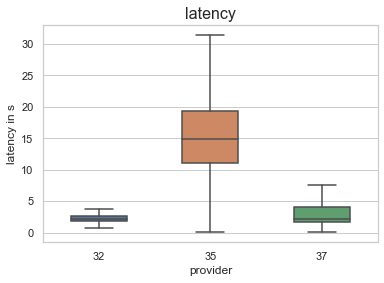

In [47]:
sn.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sn.boxplot(x= "provider", y= "latency", width=0.5, data=df, showfliers = False)
ax.set(xlabel='provider', ylabel='latency in s')

#Title
plt.title('latency', fontsize = 16)

Text(0.5, 1.0, 'GNSS_quality')

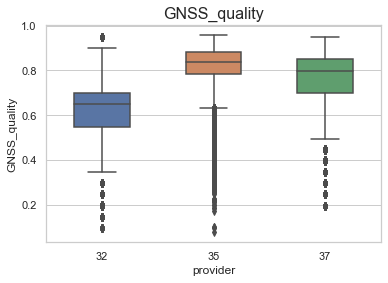

In [42]:
sn.set_theme(style="whitegrid")
fig, ax = plt.subplots()
#fig, ax = plt.subplots(figsize=(15,8))
ax = sn.boxplot(x= "provider", y= "GNSS_quality", width=0.5, data=df, showfliers = True)
ax.set(xlabel='provider', ylabel='GNSS_quality')

#Title
plt.title('GNSS_quality', fontsize = 16)


Text(0.5, 1.0, 'mobile_quality')

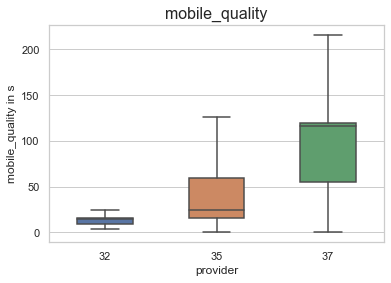

In [49]:
sn.set_theme(style="whitegrid")
fig, ax = plt.subplots()
#fig, ax = plt.subplots(figsize=(15,8))
ax = sn.boxplot(x= "provider", y= "mobile_quality", width=0.5, data=df, showfliers = False)
ax.set(xlabel='provider', ylabel='mobile_quality in s')

#Title
plt.title('mobile_quality', fontsize = 16)

# Tests

In [ ]:
df.boxplot(column= 'mobile_quality', by = 'provider')

In [ ]:
df_prov = df.groupby(['provider']).agg(
    {'mobile_quality': ['mean', 'std'],
    'GNSS_quality': ['mean', 'std'],
    'latency': ['mean', 'std']}).reset_index()

In [ ]:
provider = df_prov['provider']
mobile_quality = df_prov['mobile_quality']
GNSS_quality = df_prov['GNSS_quality']
latency = df_prov['latency']

In [ ]:
fig, ax = plt.subplots()
plt.style.use(['mystyle'])
ax.bar(provider, mobile_quality['mean'])
ax.set(xticks = provider)

In [5]:
d = {'col1': [1, 2, 1, 2, 1, 2, 1, 2, 1, 2], 'col2': [3.456, 4.852, 5.565, 6.232, 2.112, 4.036, 5.059, 9.435, 2.252, 5.142]}
df_test = pd.DataFrame(data=d)
df_test

,col1,col2
0,1,3.456
1,2,4.852
2,1,5.565
3,2,6.232
4,1,2.112
5,2,4.036
6,1,5.059
7,2,9.435
8,1,2.252
9,2,5.142


Text(0.5, 1.0, 'quality')

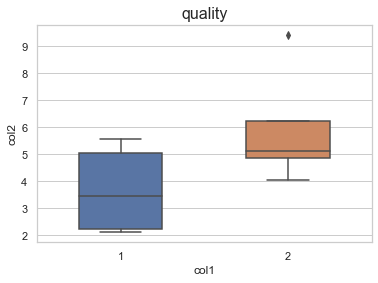

In [8]:
sn.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax = sn.boxplot(x= "col1", y= "col2", width=0.5, data=df_test)
#Title
plt.title('quality', fontsize = 16)